In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import gc
import numpy as np

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
d_input = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (4, 4), strides=2, padding="same")(d_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, (4, 4), strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, (4, 4), strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, (4, 4), strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
features = layers.Flatten()(x)
x = layers.Dropout(0.4)(features)
x = layers.Dense(1, activation="sigmoid")(x)

discriminator = Model(d_input, x, name='discriminator')
feature_model = Model(d_input, features, name='feature_model')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)       

In [5]:
generator = tf.keras.Sequential(
    [
        layers.Input(shape=(100,)),
        layers.Dense(4096),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), padding="same", activation="tanh"),
    ],
    name='generator'
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0 

In [6]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # print(real_images.shape)
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Combine them with real images
        combined_images = tf.concat([real_images, generated_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        # labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        self.discriminator.trainable=False
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.discriminator.trainable=True
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [16]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=100)

In [14]:
gc.collect()

1258

In [20]:
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

history=gan.fit(
    x_train,
    epochs= 30,
    batch_size=128,
    shuffle=True
)

Epoch 1/30
391/391 [==============================] - 31s 69ms/step - d_loss: 0.6918 - g_loss: 0.7167
Epoch 2/30
391/391 [==============================] - 26s 67ms/step - d_loss: 0.6918 - g_loss: 0.7132
Epoch 3/30
391/391 [==============================] - 26s 66ms/step - d_loss: 0.6912 - g_loss: 0.7142
Epoch 4/30
391/391 [==============================] - 26s 66ms/step - d_loss: 0.6908 - g_loss: 0.7137
Epoch 5/30
391/391 [==============================] - 26s 67ms/step - d_loss: 0.6907 - g_loss: 0.7157
Epoch 6/30
391/391 [==============================] - 26s 66ms/step - d_loss: 0.6918 - g_loss: 0.7163
Epoch 7/30
391/391 [==============================] - 26s 66ms/step - d_loss: 0.6908 - g_loss: 0.7136
Epoch 8/30
391/391 [==============================] - 26s 66ms/step - d_loss: 0.6908 - g_loss: 0.7170
Epoch 9/30
391/391 [==============================] - 26s 66ms/step - d_loss: 0.6909 - g_loss: 0.7135
Epoch 10/30
391/391 [==============================] - 26s 66ms/step - d_loss: 0.6

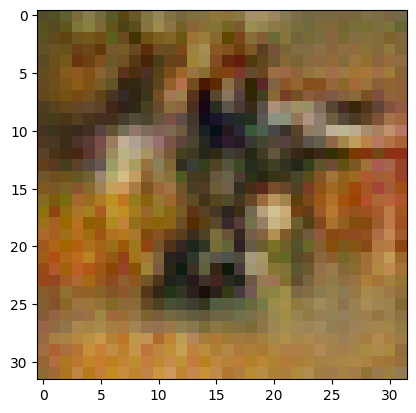

In [28]:
noise = tf.random.normal(shape=(1, 100))
pic = generator(noise)
plt.imshow(pic[0])

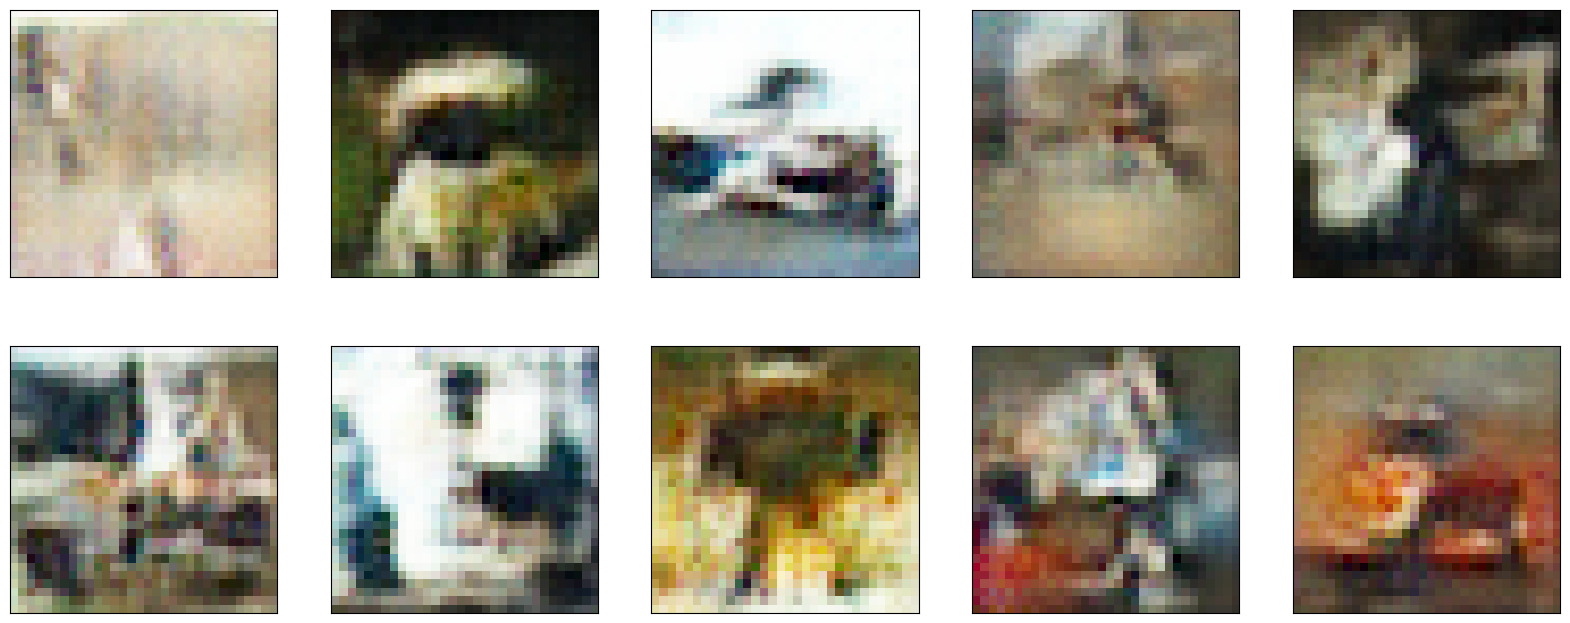

In [24]:
plt.figure(figsize=(20, 8))
for i in range(10):
        noise = tf.random.normal(shape=(1, 100))
        pic = generator(noise)
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(pic[0])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


plt.show()

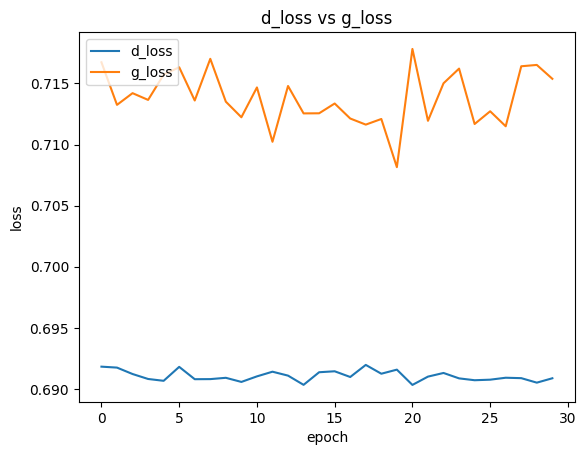

In [29]:
from matplotlib import pyplot as plt
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('d_loss vs g_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()

In [30]:
featrues = feature_model.predict(x_train)

1563/1563 [==============================] - 5s 3ms/step


In [31]:
featrues.shape

(50000, 1024)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest_clf = RandomForestClassifier(max_depth=20, random_state=0)
forest_clf.fit(featrues, y_train)

<ipython-input-32-7fc9ba5cad06>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_clf.fit(featrues, y_train)


RandomForestClassifier(max_depth=20, random_state=0)

In [33]:
featrues_test = feature_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [34]:
y_pred = forest_clf.predict(featrues_test)
accuracy_score(y_test, y_pred)

0.4539